This notebook provides an example of how to reproduce the main figures in Parkes et al.
(https://www.biorxiv.org/content/10.1101/2022.05.13.491642v1).

It also connects many of the equations in the text with the python functions that implement them.

In [1]:
# load packages
import os, sys
import numpy as np
import scipy as sp
from scipy import stats
import pandas as pd
from tqdm import tqdm
from bct.algorithms.distance import distance_wei_floyd

# load functions from this repo
from pfactor_gradients.energy import matrix_normalization, expand_states, minimum_energy_fast, simulate_natural_dynamics
from pfactor_gradients.utils import get_states_from_brain_map, rank_int, mean_over_states, get_null_p
from pfactor_gradients.plotting import my_reg_plot, my_distpair_plot, my_null_plot
from pfactor_gradients.geomsurr import geomsurr
from pfactor_gradients.communicability import matching_index, cumulative_transitivity_differences

# setup oct2py to run matlab functions from Brain Connectivity Toolbox
# note, not all bct functions are a part of bctpy
from oct2py import octave
sys.path.append('usr/local/bin/octave')  # octave install path
octave.addpath('/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/matlab_functions/bct')  # path to BCT matlab functions

# setup plotting
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='whitegrid', context='talk', font_scale=1, font='Helvetica')
figsize = 5
fontsize = 14

## Load data

In [2]:
# directory where data is stored
datadir = '/Users/lindenmp/Google-Drive-Penn/work/research_projects/pfactor_gradients/data'

# load adjacency matrix, A.
# here, this a weighted undirected structural connectome averaged over 793 participants from the PNC
# and thresholded for edge consistency (edges must have been present in at least 60% of participants)
A = np.load(os.path.join(datadir, 'A.npy'))
n_parcels = A.shape[0]

# load spatial coordinates of brain parcellation
parcellation_centroids = pd.read_csv(os.path.join(datadir, 'parcellation_centroids.csv'))
parcellation_centroids.set_index('Label Name', inplace=True)

# load the sensory-fugal axis that will serve as our basis for defining brain states
cortical_gradient = np.load(os.path.join(datadir, 'sf_axis.npy'))

In [3]:
# create states from cortical_gradient.
# this will generate groups of regions that we can use to examine
# trans-hierarchical state transitions using network control theory
bin_size = 10 # define the number of regions per brain state
n_states = int(n_parcels / bin_size) # get number of states

# get states using the sf axis.
# this will create a vector of integer values that denote which nodes belong to which state
states = get_states_from_brain_map(brain_map=cortical_gradient, n_bins=n_states)
print(states)

[ 6  3  0  2  7  4 16 11 18  3  0  1 11  2  0  1  5  2  3  1 14  0  4  9
  3  6  5  3 15  7  5  0  4  8 11  2 11 13  1 17 17 14 12 13 14  2 17 16
  9 15 11 18 19 17 19 19  6  4  5 12  3 14  8  4 10  9 16 12  9  7 15  3
 15 13 10 13  6  9 10 18 16 15 18 17 15  5 17 17 16 11  6 10 14 12 11 14
 12 18  9  7  8  2  0  0  6  1  9 17  2  4  1  2  3  2  1  0  5  0  1  1
  7  1  0  4 10 10  6  8 10  2 11  4  4  7  4  8  8  8 18 10  3 13 15 18
 19 13 12  8 10  5 16 12 11  6  6 15 19 16 18 17 19 19 18 19  7  5  5  8
 10 14 17 15 13 14  9  8 14 12  9  9  3 11 13 13 13  7 15 18 16 12 19 16
 14  7 12 19 16  5  7  6]


In [4]:
# get hierarchy distance between states.
# this creates a n_states * n_states matrix that encodes how far apart pairs of states are along the hierarchy.
# see mean_over_states for more details
states_distance = mean_over_states(cortical_gradient, states)
states_distance = np.abs(states_distance) # convert to absolute distance since sign is not meaningful here

# Compute control energy

We start by computing the minimum energy required to complete trans-hierarchical state transitions using
tools from network control theory. Taking our A matrix as an input, we first apply the following normalization:

$$ \boldsymbol{A} = {\boldsymbol{A} \over \lambda(\boldsymbol{A})_{max} + c} - I $$

We include a function called `matrix_normalization` that achieves this goal.
See https://www.biorxiv.org/content/10.1101/2022.05.13.491642v1 for more details.

In [5]:
c = 1
A_norm = matrix_normalization(A, version='continuous', c=c)

Upon this normalized A matrix, we simulate network dynamics using the following noise-free linear continuous-time
and time-invariant model:

$$ \dot{x} = \boldsymbol{A} x(t) + B_{\kappa} u_{\kappa} (t)$$

With this model, we compute the control inputs, $u_{\kappa}(t)$, that drive the system from some initial state, $x_0$,
to some target state, $x^*$, in a finite amount of time, $T$. From the many possible inputs, here we choose the
minimum energy input which minimizes a quadratic cost on the inputs, such that:

$$ E_{min} = \int _{0} ^{T} u_{\kappa} ^\top (t) u_{\kappa} (t) dt $$

As mentioned in the text, we construct a useful mathematical object called the controllability Gramian, which given by:

$$ \boldsymbol{W}_c = \int _{0} ^{T} e ^{\boldsymbol{A} t} B B ^\top e ^{\boldsymbol{A} ^\top t} d t $$

Then, using $\boldsymbol{W}_c$, minimum energy is given by:

$$ E _{min} = ( e ^{\boldsymbol{A} t} x_0 - x^* ) ^{\top} \boldsymbol{W} _c ^{-1} ( e ^{\boldsymbol{A} t} x_0 - x^* )$$

These equations are implemented in a function called `minimum_energy_fast` that computes minimum energy for all
possible state transitions that comprise a set of states.
See https://www.biorxiv.org/content/10.1101/2022.05.13.491642v1 for more details.

In [6]:
# define control nodes using the diagonals of the matrix, B.
# here, we use the identity matrix which amounts to designating all nodes as control nodes with equal weights
B = np.eye(n_parcels)

# set time horizon. here, we set T=1
T = 1

# create paired matrices that encode all possible state transitions
# the expand_states function will return two matrices with paired columns
# that is, x0_mat[:, 0] encodes the initial state, x0, and xf_mat[:, 0] encodes the final state, x*, for the first state transition
x0_mat, xf_mat = expand_states(states=states)

# get minimum control energy for all state transitions
e = minimum_energy_fast(A_norm, T, B, x0_mat, xf_mat)
# reshape to n_states * n_states matrix, where initial states will be on rows and target states on columns
# the upper triangle of e stores bottom-up energy and the lower triangle stores top-down
e = e.reshape(n_states, n_states)

# normalize energy
e = rank_int(e)

# compute energy asymmetry matrix by subtracting transpose
# the upper triangle of ed stores bottom-up minus top-down
ed = e - e.transpose()

## Plot

Now that we've computed energy for our trans-hierarchical state transitions, as well as the associated asymmetries,
let's plot them

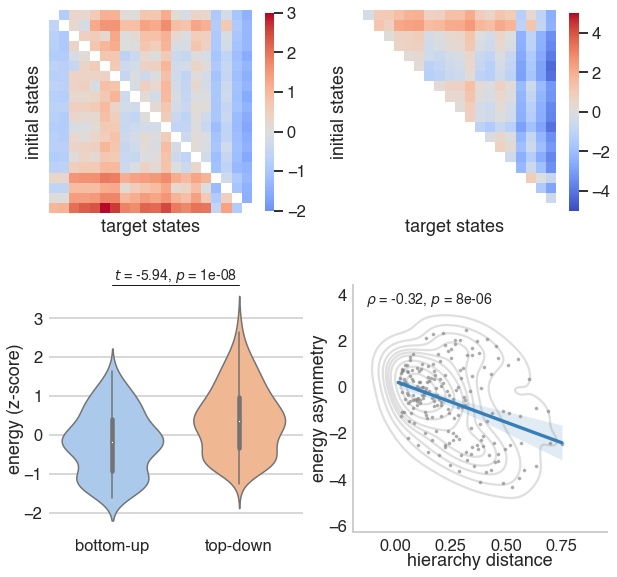

In [7]:
f, ax = plt.subplots(2, 2, figsize=(figsize*2, figsize*2))

# plot energy matrix
plot_mask = np.eye(n_states)
plot_mask = plot_mask.astype(bool)
sns.heatmap(e, mask=plot_mask, center=0, vmin=np.floor(np.min(e[~plot_mask])), vmax=np.ceil(np.max(e)),
            square=True, cmap='coolwarm', ax=ax[0,0], cbar_kws={"shrink": 0.80})
ax[0,0].set_ylabel("initial states", labelpad=-1)
ax[0,0].set_xlabel("target states", labelpad=-1)
ax[0,0].set_yticklabels('')
ax[0,0].set_xticklabels('')
ax[0,0].tick_params(pad=-2.5)

# plot energy asymmetry matrix
plot_mask = np.zeros((n_states, n_states))
indices_lower = np.tril_indices(n_states, k=-1)
plot_mask[indices_lower] = 1
plot_mask[np.eye(n_states) == 1] = 1
plot_mask = plot_mask.astype(bool)
sns.heatmap(ed, mask=plot_mask, center=0, vmin=np.floor(np.min(ed)), vmax=np.ceil(np.max(ed)),
            square=True, cmap='coolwarm', ax=ax[0,1], cbar_kws={"shrink": 0.80})
ax[0,1].set_ylabel("initial states", labelpad=-1)
ax[0,1].set_xlabel("target states", labelpad=-1)
ax[0,1].set_yticklabels('')
ax[0,1].set_xticklabels('')
ax[0,1].tick_params(pad=-2.5)

# plot top-down vs bottom-up energy distributions
indices_upper = np.triu_indices(n_states, k=1)
df_plot = pd.DataFrame(data=np.vstack((e[indices_upper], e[indices_lower])).transpose(),
                       columns=['bottom-up', 'top-down'])
my_distpair_plot(df=df_plot, ylabel='energy (z-score)', ax=ax[1,0], fontsize=fontsize)

# plot correlation between hierarchical distance and energy asymmetries
my_reg_plot(states_distance[indices_upper], ed[indices_upper],
            'hierarchy distance', 'energy asymmetry', ax[1,1],
            annotate='spearman', fontsize=fontsize)

plt.show()

# Compute null network model

The above plots show us that, in general, bottom-up energy is lower than top-down, and that this (negative) asymmetry
is larger for pairs of states that are separated by greater distances along the sensory-fugal axis ($\rho = -0.32$).

Next, we'll use a null network model to probe these effects more closely in order to understand what drives them.
Here, a null network model involves randomly rewiring our $\boldsymbol{A}$ matrix $n$ times, each time preserving the
nodes' spatial embedding and as well as the network's strength distribution. For speed, here we $n=1000$, but in the
manuscript we use $n=10000$. See https://www.biorxiv.org/content/10.1101/2022.05.13.491642v1 for more details.

In [8]:
# get distance matrix
# in order to preserve nodes' spatial embedding, we need to use their coordinates to compute a distance matrix
D = sp.spatial.distance.pdist(parcellation_centroids, 'euclidean')
D = sp.spatial.distance.squareform(D)

n_perms = 1000
r_network_null = np.zeros(n_perms)

for i in tqdm(np.arange(n_perms)):
    np.random.seed(i)

    # use geomsurr to rewire A. here, we focus on Wsp, which is A rewired to preserve space and strength distribution
    # see Roberts et al. NeuroImage 2016 for more details.
    # if you use geomsurr from this repo, please cite their paper
    Wwp, Wsp, Wssp = geomsurr(W=A, D=D)

    # normalize rewired A
    A_wsp_norm = matrix_normalization(Wsp, version='continuous', c=c)

    # compute control energy between all states using the same params as above
    e_wsp = minimum_energy_fast(A_wsp_norm, T, B, x0_mat, xf_mat)
    e_wsp = e_wsp.reshape(n_states, n_states)

    # normalize
    e_wsp = rank_int(e_wsp)

    # get asymmetry
    ed_wsp = e_wsp - e_wsp.transpose()

    # compute correlation with hierarchy distance
    r_network_null[i] = sp.stats.spearmanr(states_distance[indices_upper], ed_wsp[indices_upper])[0]

100%|██████████| 1000/1000 [21:37<00:00,  1.30s/it]


## Plot

`r_network_null` stores a distribution of correlations between hierarchy distance and energy asymmetries generated from
$n$ permuted $\boldsymbol{A}$ matrices. We use this distribution as an empirical null to compare our observed distance
correlation against.

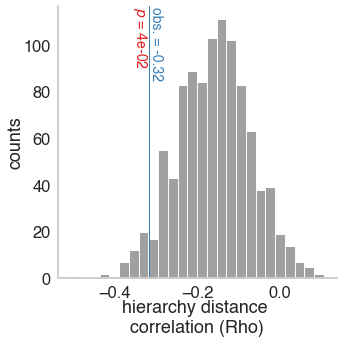

In [9]:
# plot correlation between hierarchical distance and energy asymmetries against empirical null
observed = sp.stats.spearmanr(states_distance[indices_upper], ed[indices_upper])[0] # get observed correlation
p_val = get_null_p(observed, r_network_null, abs=True) # compute p-value against null
f, ax = plt.subplots(1, 1, figsize=(figsize, figsize))
my_null_plot(observed=observed, null=r_network_null, p_val=p_val,
             xlabel='hierarchy distance \ncorrelation (Rho)',
             ax=ax, fontsize=fontsize)
plt.show()

We can see that our observed correlation of $\rho = -0.32$ is significantly larger (in absolute terms) than the
correlations that make up the empirical null distribution. Thus, we reject the null hypothesis that our distance effect
was generated by a combination of spatial embedding and the strength distribution.

# Compute communicability metrics

Having demonstrated that energy asymmetries were not explained by spatial embedding or strength, we next seek to
characterize them further by comparing with other metrics of topology that are also sensitive to asymmetry.
Specifically, we compare against diffusion efficiency, search information, and a modified version of path transitivity
(see https://www.biorxiv.org/content/10.1101/2022.05.13.491642v1 for more details).


In [10]:
# convert weights to length
L = 1/A
L[np.isinf(L)] = 0

# use matlab version of bct to compute diffusion efficiency
_, de = octave.diffusion_efficiency(A, nout=2)
ded = de - de.transpose() # compute asymmetry
ded_states = mean_over_states(ded, states) # average over connections between states

# use matlab version of bct to compute search information
si = octave.search_information(A, L, has_memory=False)
sid = si - si.transpose() # compute asymmetry
sid_states = mean_over_states(sid, states) # average over connections between states

# get shortest paths between all nodes
D, hops, Pmat = distance_wei_floyd(L, transform=None)

# compute matching index (see Goni et al. PNAS 2014)
m = matching_index(A)

# compute modified version of path transitivity that is sensitive to asymmetries
# this function computes cumulative path transitivity for segments of the shortest path
# that start from either end of the shortest path.
# then it subtracts the corresponding curves and sums the differences, creating an asymmetric measure
# of cumulative path transitivity
ptcd = cumulative_transitivity_differences(m, hops, Pmat)
ptcd_states = mean_over_states(ptcd, states) # average over connections between states

/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/Users/lindenmp/opt/anaconda3/envs/pfactor_gradients/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Key - value pairs are deprecated, use `func_args`
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 200/200 [00:23<00:00,  8.61it/s]


## Plot

Below we correlate energy asymmetries with each of the above communicability asymmetries

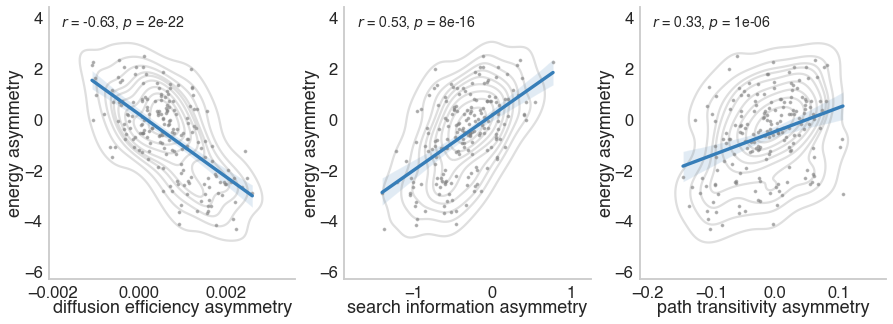

In [11]:
f, ax = plt.subplots(1, 3, figsize=(figsize*3, figsize))
my_reg_plot(ded_states[indices_upper], ed[indices_upper],
            'diffusion efficiency asymmetry', 'energy asymmetry', ax[0],
            annotate='pearson', bonferroni=3, fontsize=fontsize)

my_reg_plot(sid_states[indices_upper], ed[indices_upper],
            'search information asymmetry', 'energy asymmetry', ax[1],
            annotate='pearson', bonferroni=3, fontsize=fontsize)

my_reg_plot(ptcd_states[indices_upper], ed[indices_upper],
            'path transitivity asymmetry', 'energy asymmetry', ax[2],
            annotate='pearson', bonferroni=3, fontsize=fontsize)
plt.show()

The above results indicate that state transitions with lower bottom-up energy (relative to top-down) are also
associated with (i) higher bottom-up diffusion efficiency; (ii) lower bottom-up search information; and (iii)
lower bottom-up cumulative path transitivity. Taken together, these results suggest that while bottom-up signaling
is more efficient than top-down (higher bottom-up diffusion efficiency), it is unlikely to follow the shortest path
(lower bottom-up search information). Additionally, returning detours are encountered sooner for top-down signaling
(lower bottom-up cumulative path transitivity), which may indicate that the early occurrence of these detours inhibits
top-down signaling.

# Simulate uncontrolled dynamics

Finally, to visualize this process of efficient bottom-up signaling, we re-run our model in absence of both state states
and control inputs. That is, we simply illustrate how uncontrolled linear dynamics, seeded from each brain states,
flows across the hierarchy according to:

$$ \dot{x} = \boldsymbol{A} x (t) $$

This is implemented in a function called `simulate_natural_dynamics`.
See https://www.biorxiv.org/content/10.1101/2022.05.13.491642v1 for more details.

In [12]:
# extract brain activity over time (simulated by our model) seeded from each state
activity = simulate_natural_dynamics(A, states, t0=0.01, h=50, ds=0.5)
print(activity.shape)

# for each seed brain state, correlate the activity at each time point with the sensory-fugal axis
# when calculating correlations over regions, we exclude the regions that comprise the seed state
activity_corr = np.zeros((n_states, activity.shape[2]))
for i in np.arange(n_states): # for each seed states
    for j in np.arange(activity.shape[2]): # for each time point
        activity_corr[i, j] = sp.stats.spearmanr(cortical_gradient[states != i], activity[i, states != i, j])[0]

(20, 200, 100)


`activity` is an $n\_states \times n\_parcels \times time$ matrix that stores node-level activity values (dimension 2) simulated
by our model over time (dimension 3) seeded from each of our brain states (dimension 1). Then, for each seed brain
state and time point, we correlate the pattern of simulated activity at each node with the sensory-fugal axis. Below,
we plot those correlations as a function of time (top panel).
We also plot the differences in these correlations between adjacent timepoints (bottom panel); doing so illustrates
how rapidly they change over time.

## Plot

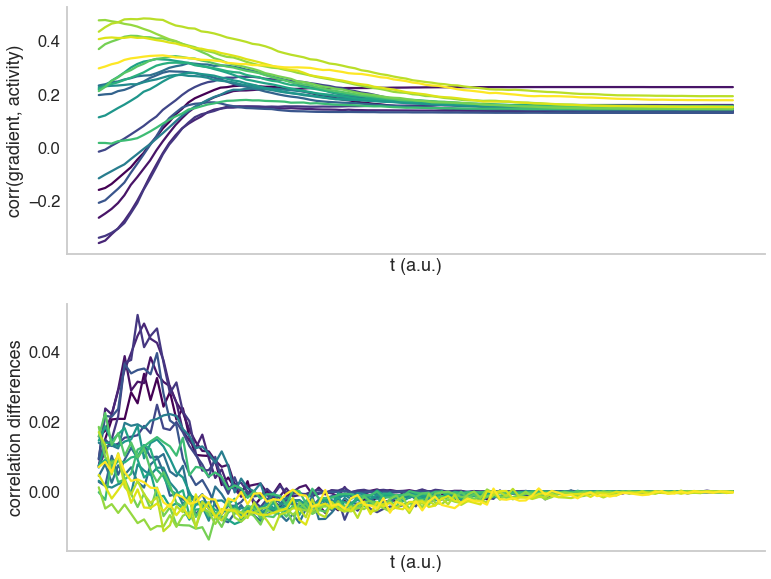

In [13]:
cmap = plt.cm.get_cmap('viridis', n_states)
# correlation with gradient at each time point
f, ax = plt.subplots(2, 1, figsize=(figsize*2.5, figsize*2))
for i in np.arange(n_states):
    ax[0].plot(np.arange(1, activity.shape[2] + 1), activity_corr[i, :], color=cmap(i))
ax[0].set_xlabel('t (a.u.)')
ax[0].set_ylabel('corr(gradient, activity)')
ax[0].tick_params(pad=-2.5)
ax[0].grid(False)
sns.despine(right=True, top=True, ax=ax[0])
ax[0].set_xticks([])

# %% Panel C
# diff correlation with gradient at each time point
for i in np.arange(n_states):
    ax[1].plot(np.arange(1, activity.shape[2]), np.diff(activity_corr[i, :]), color=cmap(i))
ax[1].set_xlabel('t (a.u.)')
ax[1].set_ylabel('correlation differences')
ax[1].tick_params(pad=-2.5)
ax[1].grid(False)
sns.despine(right=True, top=True, ax=ax[1])
ax[1].set_xticks([])

plt.show()